<a href="https://colab.research.google.com/github/itswwong/csm148-project/blob/main/CS148_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Set Explanation

Our team selected the Sleep Health and Lifestyle Dataset, which contains information about individuals’ demographics, daily habits, physical health, and sleep patterns.

## 2. Main Features

We are studying how Stress, Activity, Steps, HR, BP, BMI, Age, Gender, and Occupation affect Quality of Sleep.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

df = pd.read_csv('data/dataset.csv')

df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


## 3. Data Cleaning

In [2]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

# Check for duplicate rows
duplicates = df.duplicated().sum()

In [3]:
# Replace "Normal Weight" with "Normal" in the original dataset
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')

In [4]:
# Create copy for cleaning
df_clean = df.copy()

# Split blood pressure into systolic and diastolic
bp_split = df_clean['Blood Pressure'].str.split('/', expand=True)
df_clean['Systolic_BP'] = pd.to_numeric(bp_split[0])
df_clean['Diastolic_BP'] = pd.to_numeric(bp_split[1])

# Create catagories based on blood pressure levels

def catagorize_bp(row):
    systolic = row['Systolic_BP']
    diastolic = row['Diastolic_BP']

    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif (130 <= systolic < 140) and (80 <= diastolic < 90):
        return 'Hypertension Stage 1'
    else:
        return 'Hypertension Stage 2'

df_clean['Blood_Pressure_Level'] = df_clean.apply(catagorize_bp, axis=1)
print(df_clean['Blood_Pressure_Level'].value_counts())

# 2. Create binary variables for sleep disorders
df_clean['Has_Sleep_Disorder'] = (df_clean['Sleep Disorder'] != 'None').astype(int)
df_clean['Has_Insomnia'] = (df_clean['Sleep Disorder'] == 'Insomnia').astype(int)
df_clean['Has_Sleep_Apnea'] = (df_clean['Sleep Disorder'] == 'Sleep Apnea').astype(int)

# 3. Create BMI numeric variable (for easier analysis)
bmi_mapping = {
    'Normal': 1,
    'Overweight': 2,
    'Obese': 3
}
df_clean['BMI_Numeric'] = df_clean['BMI Category'].map(bmi_mapping)

# 4. Create age groups for better analysis
df_clean['Age_Group'] = pd.cut(df_clean['Age'],
                               bins=[0, 30, 40, 50, 100],
                               labels=['Young Adult', 'Adult', 'Middle Age', 'Senior'])

# 5. Create physical activity level categories
df_clean['Activity_Level'] = pd.cut(df_clean['Physical Activity Level'],
                                   bins=[0, 30, 60, 100],
                                   labels=['Low', 'Moderate', 'High'])

df_clean.describe(include='all')

Blood_Pressure_Level
Hypertension Stage 2    224
Hypertension Stage 1    108
Normal                   41
Elevated                  1
Name: count, dtype: int64


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,...,Sleep Disorder,Systolic_BP,Diastolic_BP,Blood_Pressure_Level,Has_Sleep_Disorder,Has_Insomnia,Has_Sleep_Apnea,BMI_Numeric,Age_Group,Activity_Level
count,374.000000,374,374.000000,374,374.000000,374.000000,374.000000,374.000000,374,374,...,155,374.000000,374.000000,374,374.0,374.000000,374.000000,374.000000,374,374
unique,NaN,2,NaN,11,NaN,NaN,NaN,NaN,3,25,...,2,NaN,NaN,4,NaN,NaN,NaN,NaN,4,3
top,NaN,Male,NaN,Nurse,NaN,NaN,NaN,NaN,Normal,130/85,...,Sleep Apnea,NaN,NaN,Hypertension Stage 2,NaN,NaN,NaN,NaN,Adult,Moderate
freq,NaN,189,NaN,73,NaN,NaN,NaN,NaN,216,99,...,78,NaN,NaN,224,NaN,NaN,NaN,NaN,133,163
mean,187.500000,NaN,42.184492,NaN,7.132086,7.312834,59.171123,5.385027,NaN,NaN,...,NaN,128.553476,84.649733,NaN,1.0,0.205882,0.208556,1.449198,NaN,NaN
std,108.108742,NaN,8.673133,NaN,0.795657,1.196956,20.830804,1.774526,NaN,NaN,...,NaN,7.748118,6.161611,NaN,0.0,0.404887,0.406821,0.549274,NaN,NaN
min,1.000000,NaN,27.000000,NaN,5.800000,4.000000,30.000000,3.000000,NaN,NaN,...,NaN,115.000000,75.000000,NaN,1.0,0.000000,0.000000,1.000000,NaN,NaN
25%,94.250000,NaN,35.250000,NaN,6.400000,6.000000,45.000000,4.000000,NaN,NaN,...,NaN,125.000000,80.000000,NaN,1.0,0.000000,0.000000,1.000000,NaN,NaN
50%,187.500000,NaN,43.000000,NaN,7.200000,7.000000,60.000000,5.000000,NaN,NaN,...,NaN,130.000000,85.000000,NaN,1.0,0.000000,0.000000,1.000000,NaN,NaN
75%,280.750000,NaN,50.000000,NaN,7.800000,8.000000,75.000000,7.000000,NaN,NaN,...,NaN,135.000000,90.000000,NaN,1.0,0.000000,0.000000,2.000000,NaN,NaN


## 4. Exploratory Data Analysis (EDA)

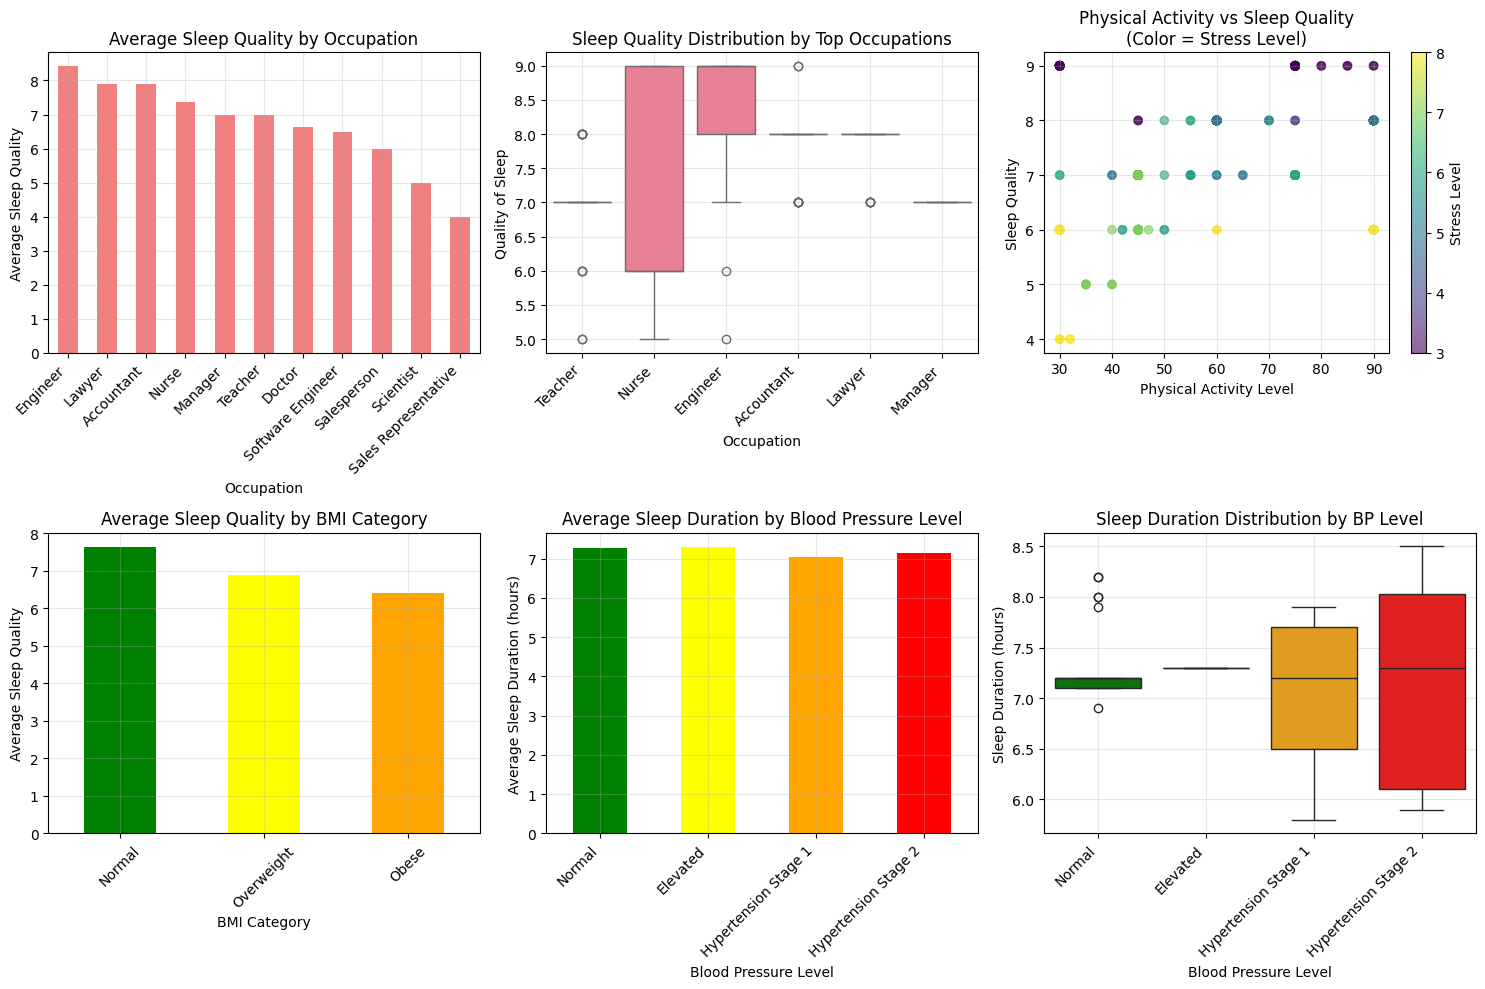

ANOVA F-statistic: 30.0222, p-value: 0.0000

Blood Pressure ANOVA F-statistic: 0.9646, p-value: 0.4095


In [5]:
# Occupation and Sleep Quality Analysis
plt.figure(figsize=(15, 10))

# Top left: Average sleep quality by occupation
plt.subplot(2, 3, 1)
occupation_sleep = df_clean.groupby('Occupation')['Quality of Sleep'].agg(['mean', 'count']).sort_values('mean', ascending=False)
occupation_sleep['mean'].plot(kind='bar', color='lightcoral')
plt.title('Average Sleep Quality by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Sleep Quality')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Top middle: Sleep quality distribution by occupation
plt.subplot(2, 3, 2)
top_occupations = occupation_sleep.head(6).index
df_top_occ = df_clean[df_clean['Occupation'].isin(top_occupations)]
sns.boxplot(data=df_top_occ, x='Occupation', y='Quality of Sleep')
plt.title('Sleep Quality Distribution by Top Occupations')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Top right: Physical activity vs sleep quality
plt.subplot(2, 3, 3)
plt.scatter(df_clean['Physical Activity Level'], df_clean['Quality of Sleep'],
           alpha=0.6, c=df_clean['Stress Level'], cmap='viridis')
plt.xlabel('Physical Activity Level')
plt.ylabel('Sleep Quality')
plt.title('Physical Activity vs Sleep Quality\n(Color = Stress Level)')
plt.colorbar(label='Stress Level')
plt.grid(True, alpha=0.3)

# Bottom left: BMI vs sleep quality
plt.subplot(2, 3, 4)
bmi_sleep = df_clean.groupby('BMI Category')['Quality of Sleep'].mean().sort_values(ascending=False)
bmi_sleep.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
plt.title('Average Sleep Quality by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Average Sleep Quality')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Bottom middle: Blood Pressure Level vs Sleep Duration
plt.subplot(2, 3, 5)
bp_order = ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2']
bp_sleep = df_clean.groupby('Blood_Pressure_Level')['Sleep Duration'].mean().reindex(bp_order)
bp_sleep.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
plt.title('Average Sleep Duration by Blood Pressure Level')
plt.xlabel('Blood Pressure Level')
plt.ylabel('Average Sleep Duration (hours)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Bottom right: Box plot showing distribution
plt.subplot(2, 3, 6)
sns.boxplot(data=df_clean, x='Blood_Pressure_Level', y='Sleep Duration',
            order=bp_order, palette=['green', 'yellow', 'orange', 'red'])
plt.title('Sleep Duration Distribution by BP Level')
plt.xlabel('Blood Pressure Level')
plt.ylabel('Sleep Duration (hours)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis of occupation effects
from scipy.stats import f_oneway

occupations = df_clean['Occupation'].unique()
occupation_groups = [df_clean[df_clean['Occupation'] == occ]['Quality of Sleep'].values
                    for occ in occupations]

f_stat, p_value = f_oneway(*occupation_groups)
print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

# Statistical analysis for Blood Pressure vs Sleep Duration
bp_groups = [df_clean[df_clean['Blood_Pressure_Level'] == bp]['Sleep Duration'].values
             for bp in bp_order if bp in df_clean['Blood_Pressure_Level'].values]

if len(bp_groups) > 1:
    f_stat_bp, p_value_bp = f_oneway(*bp_groups)
    print(f"\nBlood Pressure ANOVA F-statistic: {f_stat_bp:.4f}, p-value: {p_value_bp:.4f}")

# Regression

We chose sleep duration as our response variable, as it is numeric and not discrete

In [6]:
# look at correlations to choose a good predictor for sleep duration
corr = df_clean.corr(numeric_only=True)
print(corr["Sleep Duration"].sort_values(ascending=False))

Sleep Duration             1.000000
Quality of Sleep           0.883213
Age                        0.344709
Person ID                  0.296305
Physical Activity Level    0.212360
Daily Steps               -0.039533
Has_Sleep_Apnea           -0.064626
Diastolic_BP              -0.166570
Systolic_BP               -0.180406
Has_Insomnia              -0.347618
BMI_Numeric               -0.349605
Heart Rate                -0.516455
Stress Level              -0.811023
Has_Sleep_Disorder              NaN
Name: Sleep Duration, dtype: float64


We decided to do stress level as our predictor variable as it has a strong negative correlation with Sleep Duration

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
traindf, testdf = train_test_split(df_clean, test_size=0.2, random_state=42)

# training arrays
y_train = np.array(traindf['Sleep Duration'])  # response variable
X_train = np.array(traindf['Stress Level'])   # predictor variable
X_train = X_train.reshape(X_train.shape[0], 1) # reshape to 2D array for sklearn

In [9]:
y_test = np.array(testdf['Sleep Duration'])  # response variable
X_test = np.array(testdf['Stress Level'])   # predictor variable
X_test = X_test.reshape(X_test.shape[0], 1) # reshape to 2D array for sklearn

In [10]:
y_train.shape, X_train.shape, y_test.shape, X_test.shape

((299,), (299, 1), (75,), (75, 1))

In [11]:
#create linear model
regression = LinearRegression()

#fit linear model
regression.fit(X_train, y_train)

predicted_y = regression.predict(X_test)

r2 = regression.score(X_test, y_test)
print(f'R^2 = {r2:.5}')

R^2 = 0.71067


In [12]:
# Calculate proper evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

# Predictions for both train and test sets
y_train_pred = regression.predict(X_train)
y_test_pred = regression.predict(X_test)

# R^2 scores
train_r2 = regression.score(X_train, y_train)
test_r2 = regression.score(X_test, y_test)

# MSE scores
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# RMSE scores
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("Evaluation Metrics: ")
print(f"Training R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")



print(f"\nModel coefficients:")
print(f"Slope: {regression.coef_[0]:.4f}")
print(f"Intercept: {regression.intercept_:.4f}")

Evaluation Metrics: 
Training R^2: 0.6416
Test R^2: 0.7107
Training MSE: 0.2221
Test MSE: 0.1926
Training RMSE: 0.4713
Test RMSE: 0.4389

Model coefficients:
Slope: -0.3572
Intercept: 9.0532


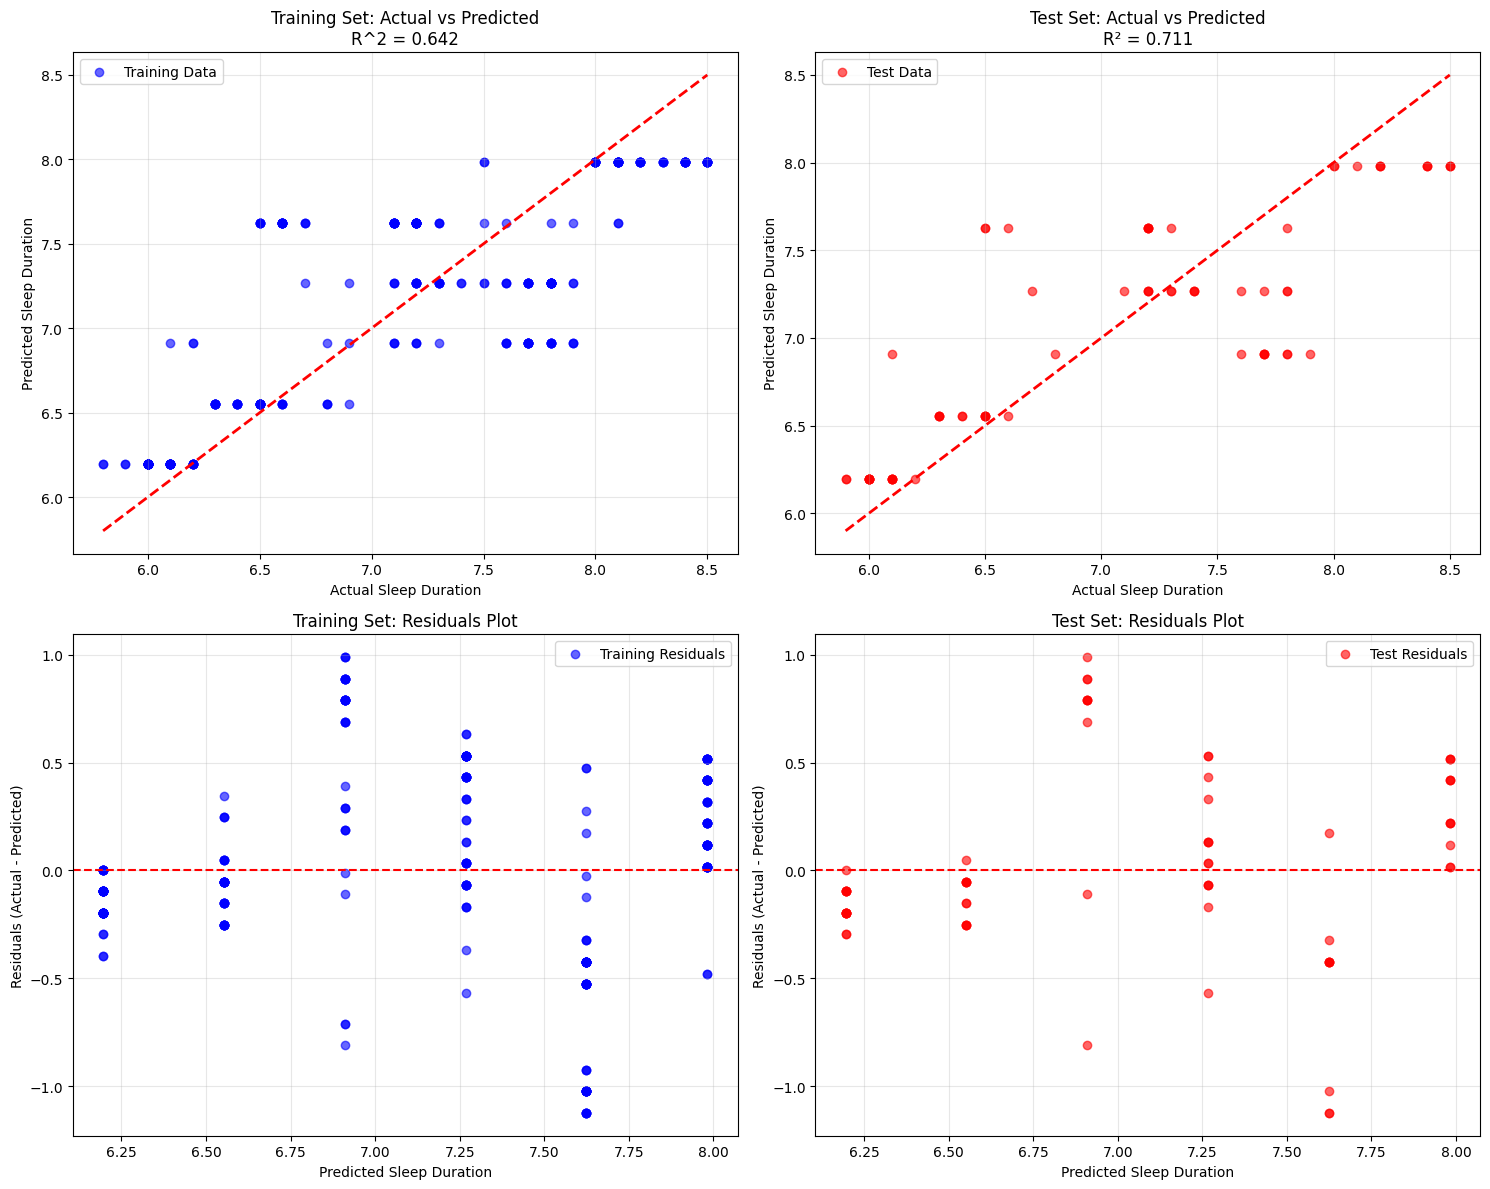

Training R^2: 0.6416
Test R^2: 0.7107


In [323]:
# Visualization to check for overfitting/underfitting
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted for Training Set
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Training Data')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sleep Duration')
axes[0, 0].set_ylabel('Predicted Sleep Duration')
axes[0, 0].set_title(f'Training Set: Actual vs Predicted\nR^2 = {train_r2:.3f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted for Test Set
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='red', label='Test Data')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Sleep Duration')
axes[0, 1].set_ylabel('Predicted Sleep Duration')
axes[0, 1].set_title(f'Test Set: Actual vs Predicted\nR² = {test_r2:.3f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals Plot for Training Set
train_residuals = y_train - y_train_pred
axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.6, color='blue', label='Training Residuals')
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Sleep Duration')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Training Set: Residuals Plot')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals Plot for Test Set
test_residuals = y_test - y_test_pred
axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.6, color='red', label='Test Residuals')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Sleep Duration')
axes[1, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 1].set_title('Test Set: Residuals Plot')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Performance comparison
print(f"Training R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")

There is no evidence of overfitting, as both the train and test data perform relatively the same, with the test set performing better and having a lower MSE. Since the training R^2 was 0.64, this doesn't necessarily indicate underfitting but show it shows the model might not be complex enought to capture the relationship between the predictor and the response variable, and can be extended to multiple linear regression. 

### Regularization

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler

In [14]:

# Select multiple columns using list syntax 
X = df_clean[['Stress Level', 'Age', 'Heart Rate', 'BMI_Numeric', 'Has_Insomnia']]
y = df_clean['Sleep Duration']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# apply the scaling to test data
X_test_scaled = scaler.transform(X_test)


Best alpha: 1.3530
Best CV RMSE: 0.6133


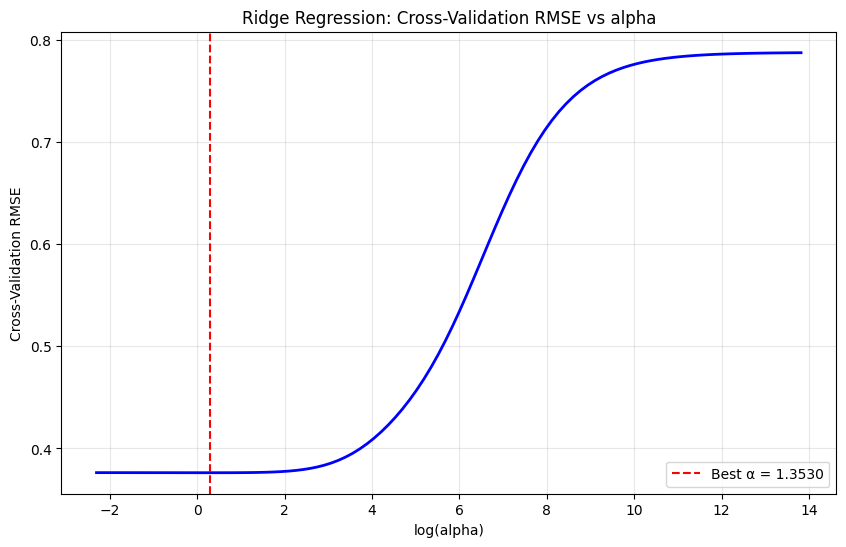

In [15]:
# use 10-fold cross-validation to select the best lambda (alpha) value for the ridge regression model

# define the alpha values to test
# note that the start/stop values in the first two arguments are the exponents
alphas = np.logspace(-1, 6, 100)

# create an empty list to store the cross-validation scores
ridge_cv_scores = []

# create a for loop to compute the cross-validation score for each alpha value
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge_cv = cross_validate(estimator=ridge,
                              X=X_train_scaled,
                              y=y_train,
                              cv=10,
                              scoring='neg_root_mean_squared_error')
    ridge_cv_scores.append({'alpha': alpha,
                            'log_alpha': np.log(alpha),
                            'test_mse': -np.mean(ridge_cv['test_score'])})

# convert the cross-validation scores into a data frame
ridge_cv_scores_df = pd.DataFrame(ridge_cv_scores)

# Find the best alpha
best_alpha_idx = ridge_cv_scores_df['test_mse'].idxmin()
best_alpha = ridge_cv_scores_df.loc[best_alpha_idx, 'alpha']
best_mse = ridge_cv_scores_df.loc[best_alpha_idx, 'test_mse']

print(f"Best alpha: {best_alpha:.4f}")
print(f"Best CV RMSE: {np.sqrt(best_mse):.4f}")

# plot the cross-validation scores as a function of alpha
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(ridge_cv_scores_df['log_alpha'], ridge_cv_scores_df['test_mse'], 'b-', linewidth=2)
plt.axvline(x=np.log(best_alpha), color='r', linestyle='--', label=f'Best α = {best_alpha:.4f}')
plt.xlabel('log(alpha)')
plt.ylabel('Cross-Validation RMSE')
plt.title('Ridge Regression: Cross-Validation RMSE vs alpha')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Final Ridge Regression Results:
Best lambda (alpha): 1.3530
Training R^2: 0.7792
Test R^2: 0.7784
Training RMSE: 0.3700
Test RMSE: 0.3841

Model coefficients:
Stress Level: -0.6311
Age: 0.2238
Heart Rate: 0.2302
Has_Sleep_Disorder: -0.3679
Has_Sleep_Apnea: -0.0447
Intercept: 7.1562


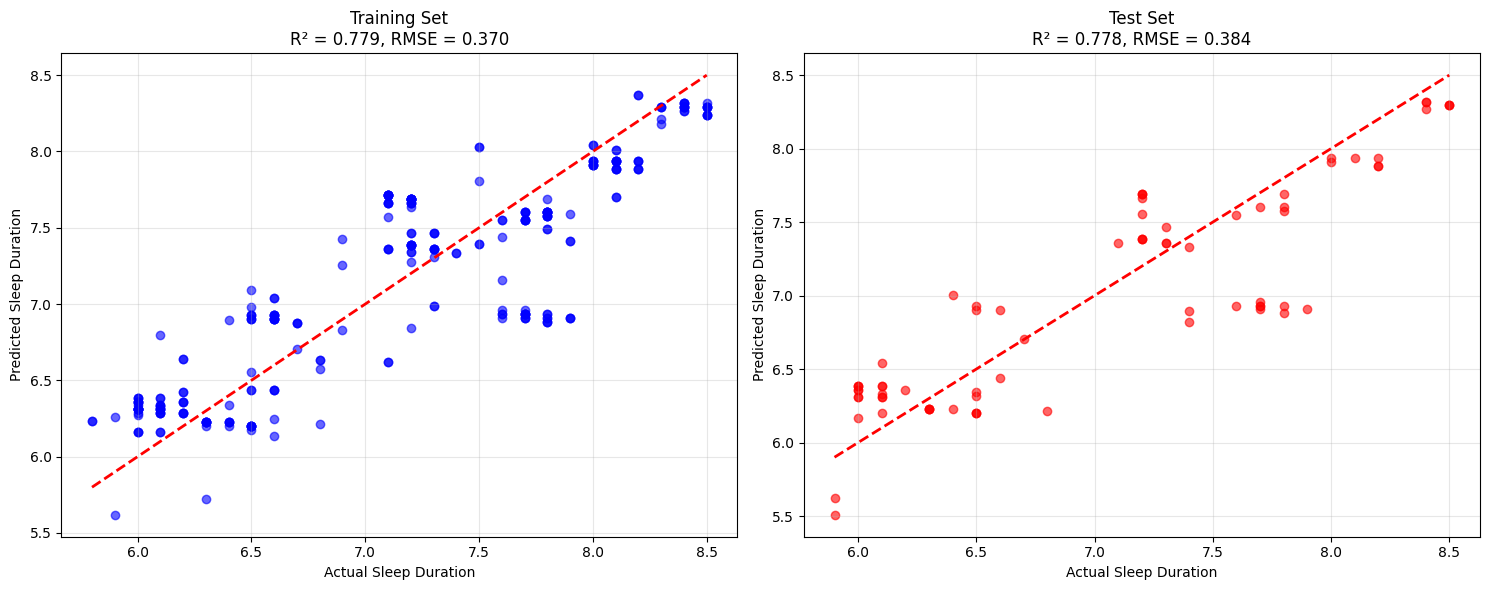

In [16]:
# train the final model with the best alpha
final_ridge = Ridge(alpha=best_alpha)
final_ridge.fit(X_train_scaled, y_train)

# Make predictions on both training and test sets
y_train_pred = final_ridge.predict(X_train_scaled)
y_test_pred = final_ridge.predict(X_test_scaled)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Final Ridge Regression Results:")
print(f"Best lambda (alpha): {best_alpha:.4f}")
print(f"Training R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Display coefficients
feature_names = ['Stress Level', 'Age', 'Heart Rate', 'Has_Sleep_Disorder', 'Has_Sleep_Apnea', 'Has_Insomnia']
print(f"\nModel coefficients:")
for name, coef in zip(feature_names, final_ridge.coef_):
    print(f"{name}: {coef:.4f}")
print(f"Intercept: {final_ridge.intercept_:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.6, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Sleep Duration')
axes[0].set_ylabel('Predicted Sleep Duration')
axes[0].set_title(f'Training Set\nR² = {train_r2:.3f}, RMSE = {train_rmse:.3f}')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, color='red')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Sleep Duration')
axes[1].set_ylabel('Predicted Sleep Duration')
axes[1].set_title(f'Test Set\nR² = {test_r2:.3f}, RMSE = {test_rmse:.3f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


We chose a few more predictor variables and used Ridge Regression to adjust the coefficients, reducing the impact of less important features.

### Logistic Regression

In [328]:
targets = ['Has_Sleep_Disorder', 'Has_Insomnia', 'Has_Sleep_Apnea']

for col in targets:
    print(df_clean[col].value_counts(normalize=True))

Has_Sleep_Disorder
1    1.0
Name: proportion, dtype: float64
Has_Insomnia
0    0.794118
1    0.205882
Name: proportion, dtype: float64
Has_Sleep_Apnea
0    0.791444
1    0.208556
Name: proportion, dtype: float64


We chose "Has_Sleep_Apnea" as our response variable since it is binary categorial.

In [329]:
# Look at correlations to choose a good predictor for "Has_Sleep_Apnea"
corr = df_clean.corr(numeric_only=True)
print(corr["Has_Sleep_Apnea"].sort_values(ascending=False))

Has_Sleep_Apnea            1.000000
Diastolic_BP               0.673079
Systolic_BP                0.611389
BMI_Numeric                0.503456
Age                        0.445719
Person ID                  0.405977
Physical Activity Level    0.385533
Heart Rate                 0.363420
Daily Steps                0.254924
Stress Level               0.081582
Quality of Sleep          -0.046254
Sleep Duration            -0.064626
Has_Insomnia              -0.261378
Has_Sleep_Disorder              NaN
Name: Has_Sleep_Apnea, dtype: float64


We decided to choose Diastolic BP, Systolic BP, BMI, and Age as our predictor variables, because these 4 variables had the highest positive correlation to having sleep apnea.

In [330]:
# Prepare data for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, roc_curve, auc, roc_auc_score)

# Select predictor variables
predictor_cols = ['Diastolic_BP', 'Systolic_BP', 'BMI_Numeric', 'Age']
X = df_clean[predictor_cols].copy()
y = df_clean['Has_Sleep_Apnea'].copy()

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [331]:
# Train the logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

print("\nModel Coefficients:")
for feature, coef in zip(predictor_cols, log_reg.coef_[0]):
    print(f"  {feature:20s}: {coef:8.4f}")
print(f"  {'Intercept':20s}: {log_reg.intercept_[0]:8.4f}")


Model Coefficients:
  Diastolic_BP        :   2.1350
  Systolic_BP         :   0.1127
  BMI_Numeric         :   0.1193
  Age                 :  -0.0579
  Intercept           :  -2.5061


In [332]:
# Make predictions on TRAINING set (using default threshold of 0.5)
y_train_pred = log_reg.predict(X_train_scaled)
y_train_pred_proba = log_reg.predict_proba(X_train_scaled)[:, 1]

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)

print("Confusion Matrix:")
print(cm_train)

Confusion Matrix:
[[232   5]
 [ 15  47]]


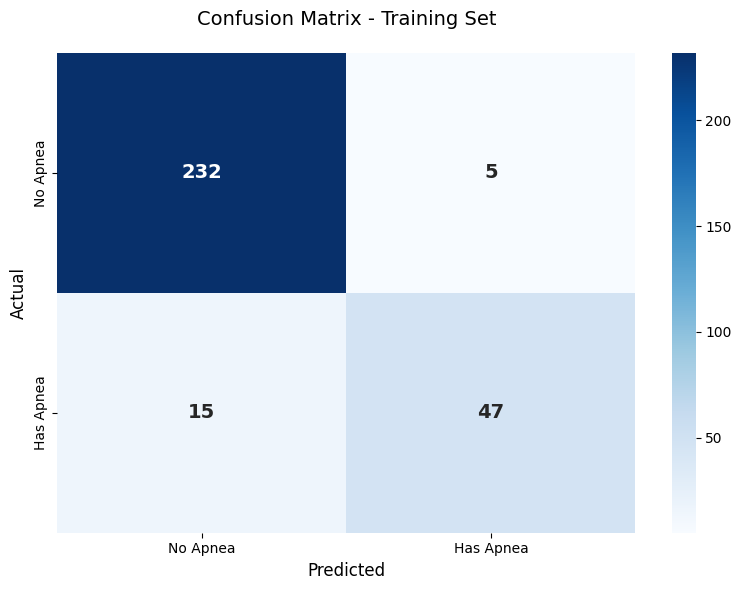

In [333]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Apnea', 'Has Apnea'],
            yticklabels=['No Apnea', 'Has Apnea'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix - Training Set',
          fontsize=14, pad=20)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

In [334]:
# Calculate metrics
TN, FP, FN, TP = cm_train.ravel()

accuracy = accuracy_score(y_train, y_train_pred)
prediction_error = 1 - accuracy
true_positive_rate = TP / (TP + FN) if (TP + FN) > 0 else 0
true_negative_rate = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
f1_score = 2 * (precision * true_positive_rate) / (precision + true_positive_rate) if (precision + true_positive_rate) > 0 else 0

print("\nPerformance Metrics:")
print(f"Prediction Accuracy: {accuracy:.4f}")
print(f"Prediction Error: {prediction_error:.4f}")
print(f"True Positive Rate (Sensitivity/Recall): {true_positive_rate:.4f}")
print(f"True Negative Rate (Specificity): {true_negative_rate:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Performance Metrics:
Prediction Accuracy: 0.9331
Prediction Error: 0.0669
True Positive Rate (Sensitivity/Recall): 0.7581
True Negative Rate (Specificity): 0.9789
Precision: 0.9038
F1-Score: 0.8246


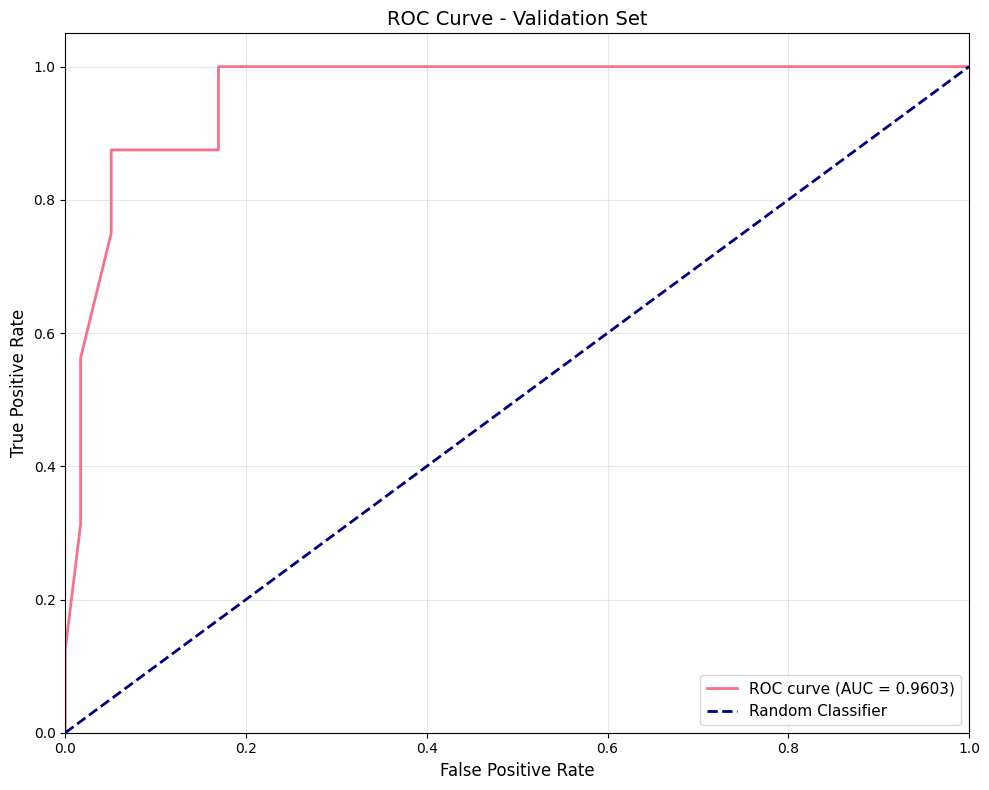


Validation Set AUC: 0.9603


In [335]:
# ROC Curve and AUC on Validation Set
y_val_pred_proba = log_reg.predict_proba(X_val_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Validation Set', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nValidation Set AUC: {roc_auc:.4f}")

5-Fold Cross-Validation Results on Validation Set:
Fold 1: Accuracy = 0.9333, AUC = 0.9306
Fold 2: Accuracy = 0.8000, AUC = 0.8333
Fold 3: Accuracy = 0.8667, AUC = 0.7500
Fold 4: Accuracy = 1.0000, AUC = 1.0000
Fold 5: Accuracy = 1.0000, AUC = 1.0000
Mean Accuracy: 0.9200 (±0.0869)
Mean AUC: 0.9028 (±0.1094)


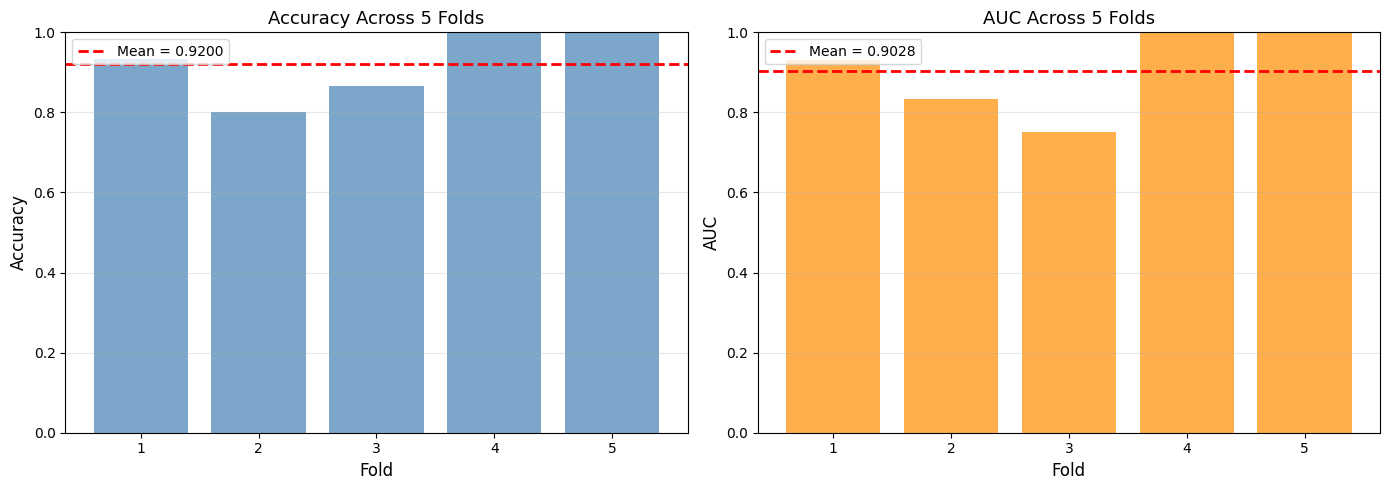

In [336]:
# 5-Fold Cross-Validation on Validation Set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_results = []

print("5-Fold Cross-Validation Results on Validation Set:")

for fold, (train_idx, test_idx) in enumerate(skf.split(X_val_scaled, y_val), 1):
    # Split validation set into folds
    X_fold_train, X_fold_test = X_val_scaled[train_idx], X_val_scaled[test_idx]
    y_fold_train, y_fold_test = y_val.iloc[train_idx], y_val.iloc[test_idx]

    # Train model on this fold
    fold_model = LogisticRegression(random_state=42, max_iter=1000)
    fold_model.fit(X_fold_train, y_fold_train)

    # Get predictions and probabilities
    y_fold_pred = fold_model.predict(X_fold_test)
    y_fold_pred_proba = fold_model.predict_proba(X_fold_test)[:, 1]

    # Calculate metrics
    fold_accuracy = accuracy_score(y_fold_test, y_fold_pred)
    fold_auc = roc_auc_score(y_fold_test, y_fold_pred_proba)

    fold_results.append({
        'Fold': fold,
        'Accuracy': fold_accuracy,
        'AUC': fold_auc
    })

    print(f"Fold {fold}: Accuracy = {fold_accuracy:.4f}, AUC = {fold_auc:.4f}")

# Calculate average metrics across folds
fold_results_df = pd.DataFrame(fold_results)
mean_accuracy = fold_results_df['Accuracy'].mean()
std_accuracy = fold_results_df['Accuracy'].std()
mean_auc = fold_results_df['AUC'].mean()
std_auc = fold_results_df['AUC'].std()

print(f"Mean Accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")
print(f"Mean AUC: {mean_auc:.4f} (±{std_auc:.4f})")

# Visualize fold results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy across folds
axes[0].bar(fold_results_df['Fold'], fold_results_df['Accuracy'], color='steelblue', alpha=0.7)
axes[0].axhline(y=mean_accuracy, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_accuracy:.4f}')
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Across 5 Folds', fontsize=13)
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# AUC across folds
axes[1].bar(fold_results_df['Fold'], fold_results_df['AUC'], color='darkorange', alpha=0.7)
axes[1].axhline(y=mean_auc, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_auc:.4f}')
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('AUC', fontsize=12)
axes[1].set_title('AUC Across 5 Folds', fontsize=13)
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Threshold Selection:
Default threshold: 0.5
Optimal threshold (based on F1-score): 0.50
Optimal F1-Score: 0.8485


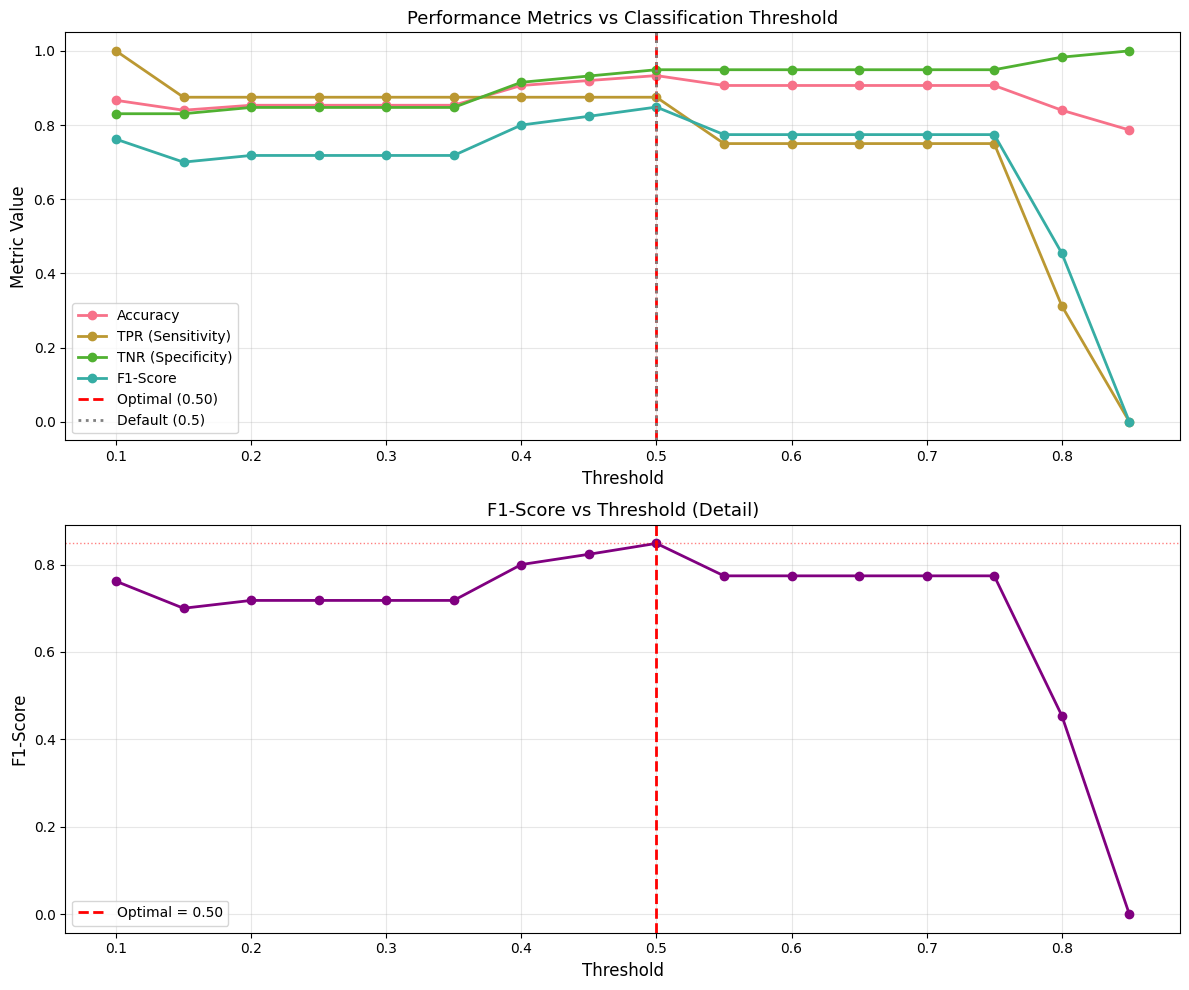

In [337]:
# Threshold Selection

# Generate predictions at different thresholds
thresholds_to_test = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds_to_test:
    y_val_pred_threshold = (y_val_pred_proba >= threshold).astype(int)

    cm = confusion_matrix(y_val, y_val_pred_threshold)
    TN, FP, FN, TP = cm.ravel()

    acc = accuracy_score(y_val, y_val_pred_threshold)
    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
    tnr = TN / (TN + FP) if (TN + FP) > 0 else 0
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1 = 2 * (prec * tpr) / (prec + tpr) if (prec + tpr) > 0 else 0

    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'TPR': tpr,
        'TNR': tnr,
        'Precision': prec,
        'F1-Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)

# Find optimal threshold (maximize F1-score)
optimal_idx = threshold_df['F1-Score'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'Threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'F1-Score']

print(f"Threshold Selection:")
print(f"Default threshold: 0.5")
print(f"Optimal threshold (based on F1-score): {optimal_threshold:.2f}")
print(f"Optimal F1-Score: {optimal_f1:.4f}")

# Plot metrics vs threshold
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot all metrics
axes[0].plot(threshold_df['Threshold'], threshold_df['Accuracy'], 'o-', label='Accuracy', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['TPR'], 'o-', label='TPR (Sensitivity)', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['TNR'], 'o-', label='TNR (Specificity)', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['F1-Score'], 'o-', label='F1-Score', linewidth=2)
axes[0].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.2f})')
axes[0].axvline(x=0.5, color='gray', linestyle=':', linewidth=2, label='Default (0.5)')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Metric Value', fontsize=12)
axes[0].set_title('Performance Metrics vs Classification Threshold', fontsize=13)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Zoom in on F1-score
axes[1].plot(threshold_df['Threshold'], threshold_df['F1-Score'], 'o-', color='purple', linewidth=2, markersize=6)
axes[1].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal = {optimal_threshold:.2f}')
axes[1].axhline(y=optimal_f1, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('F1-Score vs Threshold (Detail)', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We chose a threshold for positive predictions by testing values from 0.1 to 0.9 and selecting the one that maximizes the F1-Score. We chose the F1-Score as our optimization criteria because it balances precision and recall Our analysis found that a threshold of 0.50 provides the optimal balance between detecting sleep apnea cases and maintaining prediction confidence, achieving an F1-Score of 0.8485.


Final Validation Set Results (Threshold = 0.50):

Confusion Matrix:
[[56  3]
 [ 2 14]]


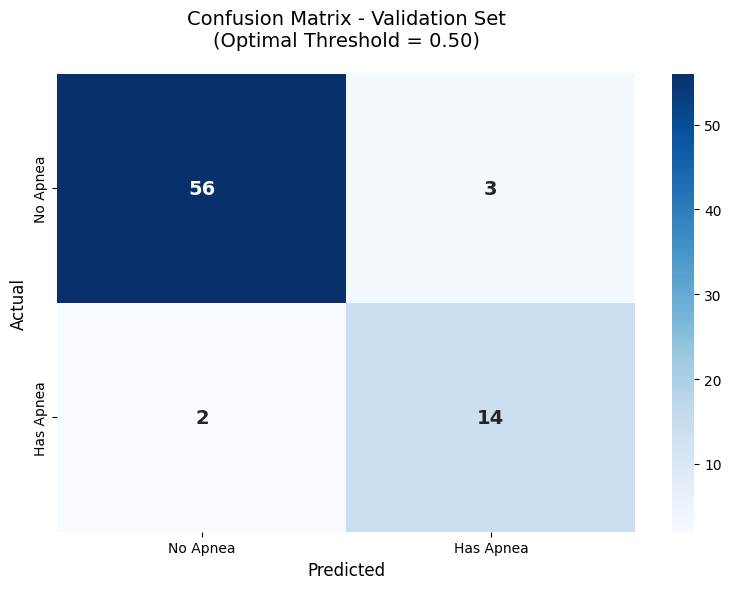


Final Performance Metrics:
Accuracy: 0.9333
Prediction Error: 0.0667
True Positive Rate (Sensitivity): 0.8750
True Negative Rate (Specificity): 0.9492
Precision: 0.8235
F1-Score: 0.8485
AUC: 0.9603


In [338]:
# Final model evaluation using optimal threshold
y_val_pred_optimal = (y_val_pred_proba >= optimal_threshold).astype(int)

cm_val_optimal = confusion_matrix(y_val, y_val_pred_optimal)
TN, FP, FN, TP = cm_val_optimal.ravel()

print(f"\nFinal Validation Set Results (Threshold = {optimal_threshold:.2f}):")
print("\nConfusion Matrix:")
print(cm_val_optimal)

# Visualize final confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_val_optimal, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Apnea', 'Has Apnea'],
            yticklabels=['No Apnea', 'Has Apnea'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title(f'Confusion Matrix - Validation Set\n(Optimal Threshold = {optimal_threshold:.2f})',
          fontsize=14, pad=20)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate final metrics
accuracy_optimal = accuracy_score(y_val, y_val_pred_optimal)
error_optimal = 1 - accuracy_optimal
tpr_optimal = TP / (TP + FN) if (TP + FN) > 0 else 0
tnr_optimal = TN / (TN + FP) if (TN + FP) > 0 else 0
precision_optimal = TP / (TP + FP) if (TP + FP) > 0 else 0
f1_optimal = 2 * (precision_optimal * tpr_optimal) / (precision_optimal + tpr_optimal) if (precision_optimal + tpr_optimal) > 0 else 0

print("\nFinal Performance Metrics:")
print(f"Accuracy: {accuracy_optimal:.4f}")
print(f"Prediction Error: {error_optimal:.4f}")
print(f"True Positive Rate (Sensitivity): {tpr_optimal:.4f}")
print(f"True Negative Rate (Specificity): {tnr_optimal:.4f}")
print(f"Precision: {precision_optimal:.4f}")
print(f"F1-Score: {f1_optimal:.4f}")
print(f"AUC: {roc_auc:.4f}")

### Random Forest Classification

We apply Random Forest Algorithm to predict `Has_Sleep_Apnea` using the same predictor set as the logistic regression: `Diastolic_BP`, `Systolic_BP`, `BMI_Numeric`, and `Age`. We train on the training split, evaluate classification metrics on the training data, and compute ROC/AUC on the validation split. Finally, we run 5-fold cross-validation on the validation split to report per-fold accuracy and AUC.


Random Forest - Training Set Confusion Matrix:
[[233   4]
 [  8  54]]

Random Forest - Training Set Metrics:
Accuracy: 0.9599
Prediction Error: 0.0401
True Positive Rate (Recall): 0.8710
True Negative Rate (Specificity): 0.9831
Precision: 0.9310
F1-Score: 0.9000


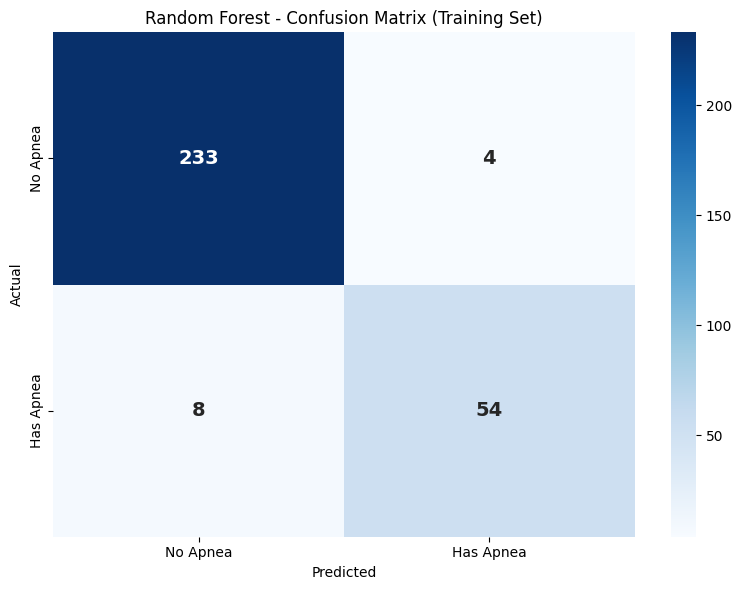

In [339]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

predictor_cols_rf = ['Diastolic_BP', 'Systolic_BP', 'BMI_Numeric', 'Age']
X_rf = df_clean[predictor_cols_rf]
y_rf = df_clean['Has_Sleep_Apnea']

X_train_rf = X_train[predictor_cols_rf]
X_val_rf = X_val[predictor_cols_rf]
y_train_rf = y_train.copy()
y_val_rf = y_val.copy()

# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight=None,
)
rf_clf.fit(X_train_rf, y_train_rf)

# Training set predictions and metrics
y_train_pred_rf = rf_clf.predict(X_train_rf)
y_train_pred_proba_rf = rf_clf.predict_proba(X_train_rf)[:, 1]
cm_train_rf = confusion_matrix(y_train_rf, y_train_pred_rf)

TN, FP, FN, TP = cm_train_rf.ravel()
accuracy_rf = accuracy_score(y_train_rf, y_train_pred_rf)
error_rf = 1 - accuracy_rf
TPR_rf = TP / (TP + FN) if (TP + FN) > 0 else 0
TNR_rf = TN / (TN + FP) if (TN + FP) > 0 else 0
precision_rf = TP / (TP + FP) if (TP + FP) > 0 else 0
f1_rf = 2 * (precision_rf * TPR_rf) / (precision_rf + TPR_rf) if (precision_rf + TPR_rf) > 0 else 0

print("Random Forest - Training Set Confusion Matrix:")
print(cm_train_rf)
print("\nRandom Forest - Training Set Metrics:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Prediction Error: {error_rf:.4f}")
print(f"True Positive Rate (Recall): {TPR_rf:.4f}")
print(f"True Negative Rate (Specificity): {TNR_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

# Visualize confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Apnea', 'Has Apnea'],
            yticklabels=['No Apnea', 'Has Apnea'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Random Forest - Confusion Matrix (Training Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


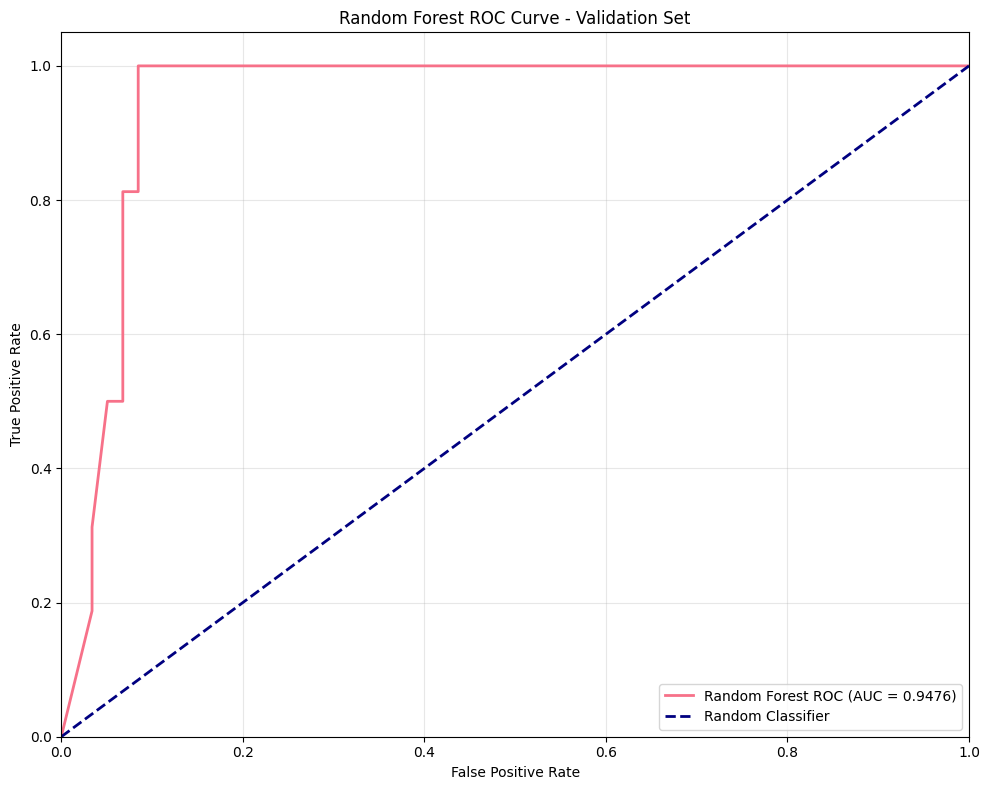

Validation Set AUC (Random Forest): 0.9476


In [340]:
# ROC Curve and AUC on Validation Set for Random Forest
y_val_pred_proba_rf = rf_clf.predict_proba(X_val_rf)[:, 1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val_rf, y_val_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest ROC (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve - Validation Set')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Validation Set AUC (Random Forest): {roc_auc_rf:.4f}")


5-Fold CV on Validation Set (Random Forest):
Fold 1: Accuracy = 0.9333, AUC = 0.9861
Fold 2: Accuracy = 0.8000, AUC = 0.8889
Fold 3: Accuracy = 0.8667, AUC = 0.9167
Fold 4: Accuracy = 0.8000, AUC = 0.9444
Fold 5: Accuracy = 1.0000, AUC = 1.0000
Mean Accuracy: 0.8800 (±0.0869)
Mean AUC: 0.9472 (±0.0465)


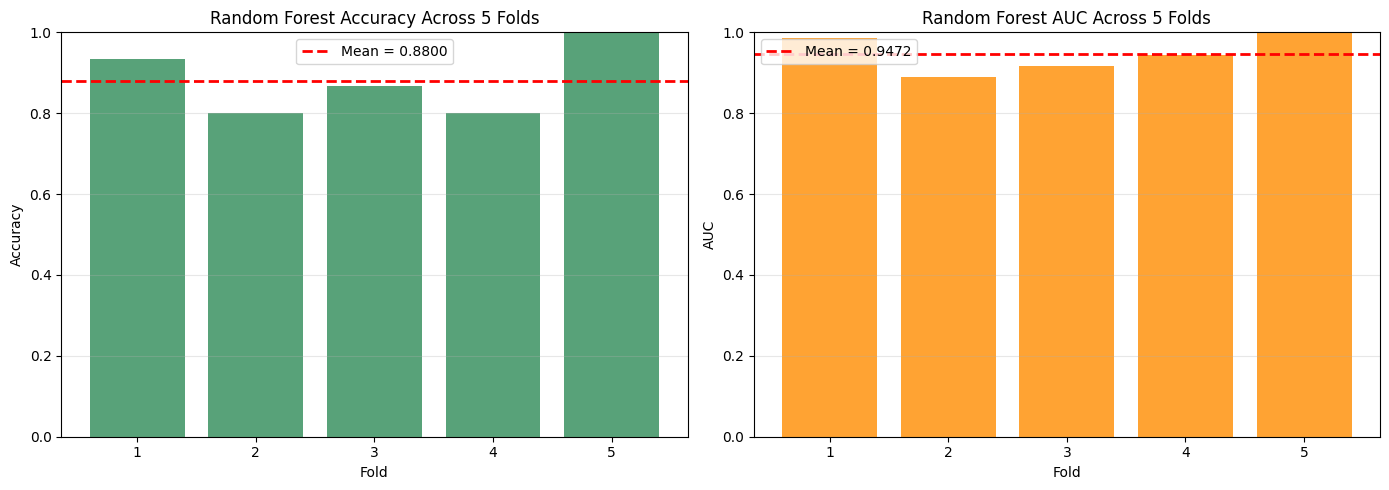

In [341]:
# 5-Fold Cross-Validation on the Validation Set for Random Forest
skf_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_results_rf = []
print("5-Fold CV on Validation Set (Random Forest):")

for fold, (tr_idx, te_idx) in enumerate(skf_rf.split(X_val_rf, y_val_rf), 1):
    X_tr, X_te = X_val_rf.iloc[tr_idx], X_val_rf.iloc[te_idx]
    y_tr, y_te = y_val_rf.iloc[tr_idx], y_val_rf.iloc[te_idx]

    fold_model = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
    )
    fold_model.fit(X_tr, y_tr)

    y_pred = fold_model.predict(X_te)
    y_proba = fold_model.predict_proba(X_te)[:, 1]

    acc = accuracy_score(y_te, y_pred)
    auc_val = roc_auc_score(y_te, y_proba)

    fold_results_rf.append({
        'Fold': fold,
        'Accuracy': acc,
        'AUC': auc_val,
    })

    print(f"Fold {fold}: Accuracy = {acc:.4f}, AUC = {auc_val:.4f}")

fold_df_rf = pd.DataFrame(fold_results_rf)
mean_acc_rf = fold_df_rf['Accuracy'].mean()
std_acc_rf = fold_df_rf['Accuracy'].std()
mean_auc_rf = fold_df_rf['AUC'].mean()
std_auc_rf = fold_df_rf['AUC'].std()

print(f"Mean Accuracy: {mean_acc_rf:.4f} (±{std_acc_rf:.4f})")
print(f"Mean AUC: {mean_auc_rf:.4f} (±{std_auc_rf:.4f})")

# Visualize fold results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(fold_df_rf['Fold'], fold_df_rf['Accuracy'], color='seagreen', alpha=0.8)
axes[0].axhline(y=mean_acc_rf, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_acc_rf:.4f}')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Random Forest Accuracy Across 5 Folds')
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(fold_df_rf['Fold'], fold_df_rf['AUC'], color='darkorange', alpha=0.8)
axes[1].axhline(y=mean_auc_rf, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_auc_rf:.4f}')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('AUC')
axes[1].set_title('Random Forest AUC Across 5 Folds')
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


The Random Forest model adds a non-linear, ensemble-based baseline alongside logistic regression. We reported training-set confusion matrix and metrics (accuracy, error, TPR, TNR, F1), validation ROC/AUC, and 5-fold CV on the validation split with per-fold accuracy and AUC.

# Principal Component Analysis

In [342]:
from sklearn.decomposition import PCA

Explained variance ratio: [4.08034673e-01 2.87450165e-01 2.12276618e-01 6.31996945e-02
 2.90388498e-02 5.76224008e-18]
Total variance explained: 1.0

Principal components shape: (299, 4)


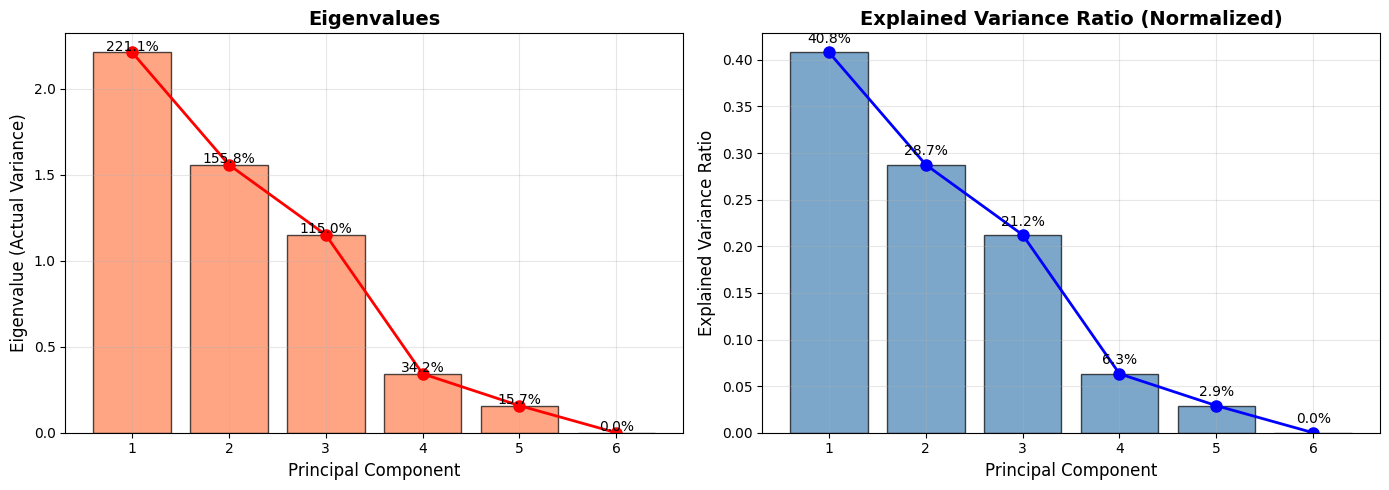

In [343]:
# need to the standardize the data
X_train_scaled_pre_PCA = X_train_scaled.copy()
X_test_scaled_pre_PCA = X_test_scaled.copy()

# apply PCA algorithm
pca = PCA()
X_train_post_PCA = pca.fit_transform(X_train_scaled_pre_PCA)
X_test_post_PCA = pca.fit_transform(X_test_scaled_pre_PCA)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))
print("\nPrincipal components shape:", X_train_post_PCA.shape)

scree_plot, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

eigenvalues = pca.explained_variance_
variance_ratios = pca.explained_variance_ratio_

#scree_plot for eigenvalues

components = range(1, len(eigenvalues) + 1)
ax1.bar(components, eigenvalues, alpha=0.7, color='coral', edgecolor='black')
ax1.plot(components, eigenvalues, 'ro-', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Eigenvalue (Actual Variance)', fontsize=12)
ax1.set_title('Eigenvalues', fontsize=14, fontweight='bold')
ax1.set_xticks(components)
ax1.grid(True, alpha=0.3)

for i, v in enumerate(eigenvalues):
    ax1.text(i + 1, v + 0.01, f'{v:.1%}', ha='center', fontsize=10)

#scree plot for explained variance ratios (% of variance per component)

ax2.bar(components, variance_ratios, alpha=0.7, color='steelblue', edgecolor='black')
ax2.plot(components, variance_ratios, 'bo-', linewidth=2, markersize=8)
ax2.set_xlabel('Principal Component', fontsize=12)
ax2.set_ylabel('Explained Variance Ratio', fontsize=12)
ax2.set_title('Explained Variance Ratio (Normalized)', fontsize=14, fontweight='bold')
ax2.set_xticks(components)
ax2.grid(True, alpha=0.3)

for i, v in enumerate(variance_ratios):
  ax2.text(i + 1, v + 0.01, f'{v:.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

#Cumulative Variablity Explained
Cumulative Variablity or Cumulative Explained Variance, is a metric to show how much of the original data's variance is captured by each principal component. In this graph, we reach 90% of the original data's variance with only 3 principle components, which is why we chose the hyper parameter of 3 components for our next PCA in the following code.

Explained variance ratio: [0.40803467 0.28745016 0.21227662]
Total variance explained: 0.907761455637851

Principal components shape: (299, 3)


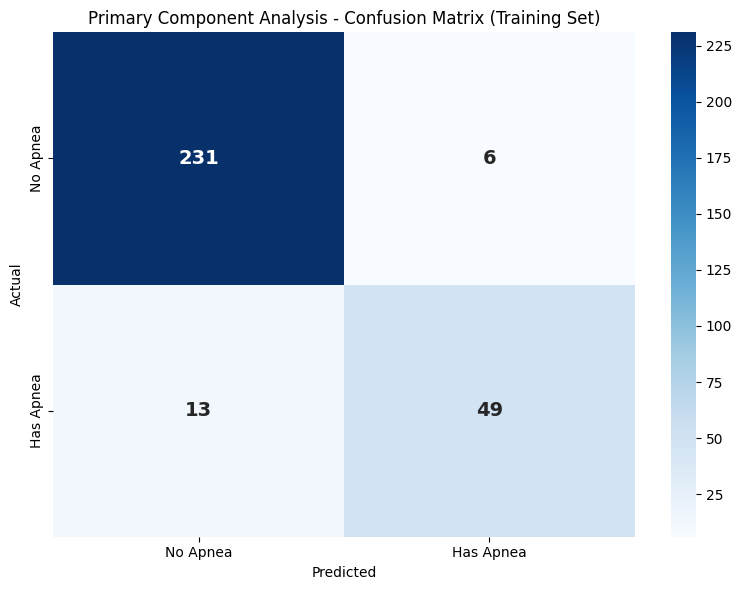

In [344]:
#applying PCA with only 3 Principal Components

X_train_scaled_pre_PCA_3 = X_train_scaled.copy()
X_test_scaled_pre_PCA_3 = X_test_scaled.copy()
y_test_pca = df_clean['Has_Sleep_Apnea']

# apply PCA algorithm
new_pca = PCA(n_components = 3)
X_train_post_PCA_3 = new_pca.fit_transform(X_train_scaled_pre_PCA_3)
X_test_post_PCA_3 = new_pca.fit_transform(X_test_scaled_pre_PCA_3)

print("Explained variance ratio:", new_pca.explained_variance_ratio_)
print("Total variance explained:", sum(new_pca.explained_variance_ratio_))
print("\nPrincipal components shape:", X_train_post_PCA_3.shape)

# evaluating the accuracy of PCA with log regression against the training set

model = LogisticRegression()
model.fit(X_train_post_PCA_3, y_train)

y_pred_pca = model.predict(X_train_post_PCA_3)

cm_pca = confusion_matrix(y_train,y_pred_pca)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Apnea', 'Has Apnea'],
            yticklabels=['No Apnea', 'Has Apnea'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Primary Component Analysis - Confusion Matrix (Training Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

#Conclusions

From applying the PCA algorithm, we help reduce the dimensionality of our training data and still retain variance and decent accuracy with the new Principal Components. This can help us with future algorithms that are computationally heavy and would be burdened by too many features.

# Clustering: Pre and Post-PCA

In [345]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score, adjusted_rand_score

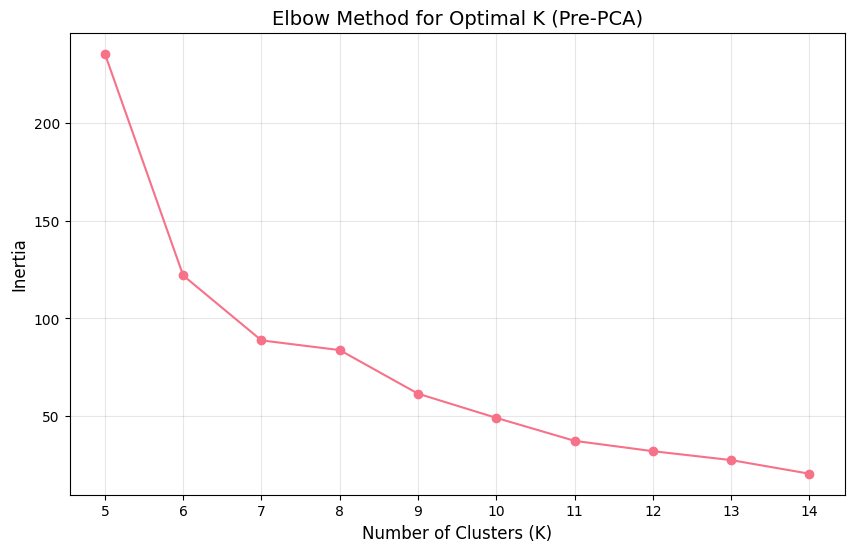

In [346]:
# Create an empty list to store the inertia values
inertia_values = []

k_range = range(5, 15, 1)

# Iterate through the range of K values
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_train_scaled)
    inertia_values.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K (Pre-PCA)', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.show()

From the elbow graph: the ideal K for this would be K=7

In [347]:
hierarchical = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='ward')
hierarchical_clusters = hierarchical.fit_predict(X_train_scaled_pre_PCA_3)

kmeans = KMeans(n_clusters=7, random_state=42, n_init='auto')
kmeans_clusters = kmeans.fit_predict(X_train_scaled_pre_PCA_3)


Comparison using Systolic and Diastolic BP

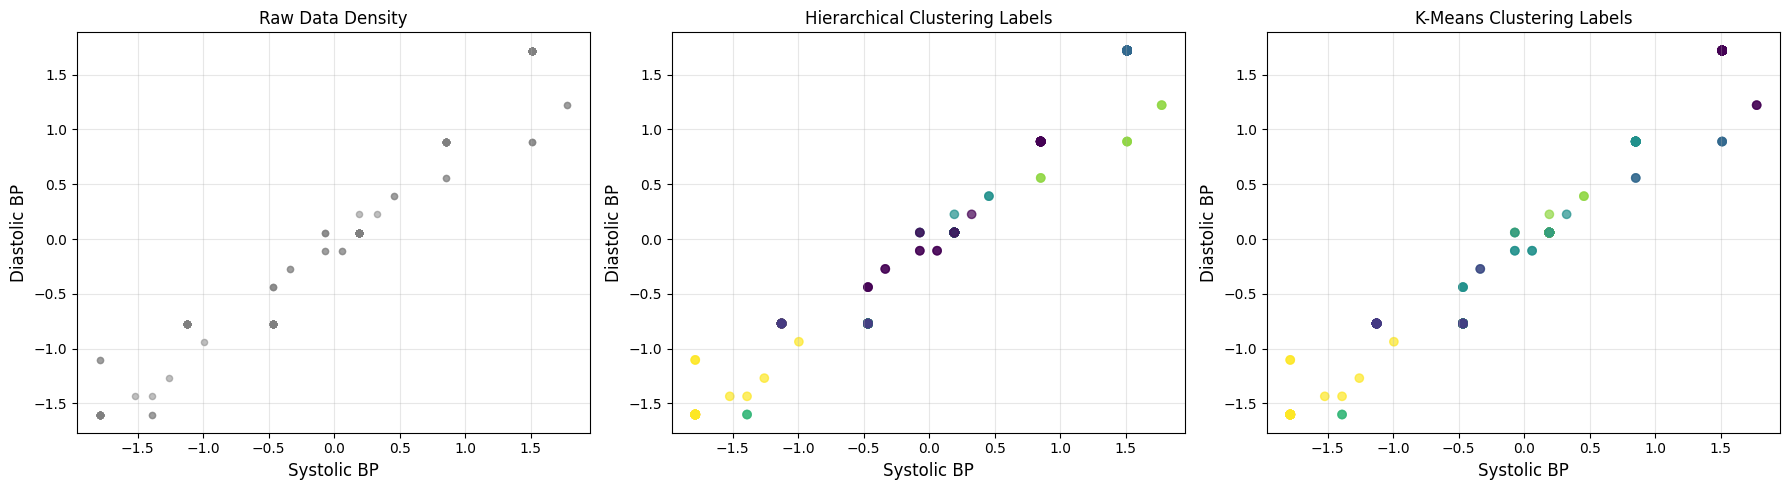

In [348]:
# X-axis: (Index 1, Feature: Systolic_BP)
x_index = 1
x_feature_name = 'Systolic_BP'

# Y-axis: (Index 0: Feature: Diastolic_BP)
y_index = 0
y_feature_name = 'Diastolic_BP'

fig, plots = plt.subplots(1, 3, figsize=(18, 5))

x = X_train_scaled_pre_PCA_3[:, x_index]
y = X_train_scaled_pre_PCA_3[:, y_index]

# Raw Data density
plots[0].scatter(x, y, c='gray', alpha=0.5, s=20)
plots[0].set_xlabel('Systolic BP', fontsize=12)
plots[0].set_ylabel('Diastolic BP', fontsize=12)
plots[0].set_title('Raw Data Density')
plots[0].grid(True, alpha=0.3)

# Hierarchical Labels
plots[1].scatter(x, y, c=hierarchical_clusters, cmap='viridis', alpha = 0.7)
plots[1].set_xlabel('Systolic BP', fontsize=12)
plots[1].set_ylabel('Diastolic BP', fontsize=12)
plots[1].set_title('Hierarchical Clustering Labels')
plots[1].grid(True, alpha=0.3)

# K-Means Labels
plots[2].scatter(x, y, c=kmeans_clusters, cmap='viridis', alpha = 0.7)
plots[2].set_xlabel('Systolic BP', fontsize=12)
plots[2].set_ylabel('Diastolic BP', fontsize=12)
plots[2].set_title('K-Means Clustering Labels')
plots[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Comparison using Age and BMI

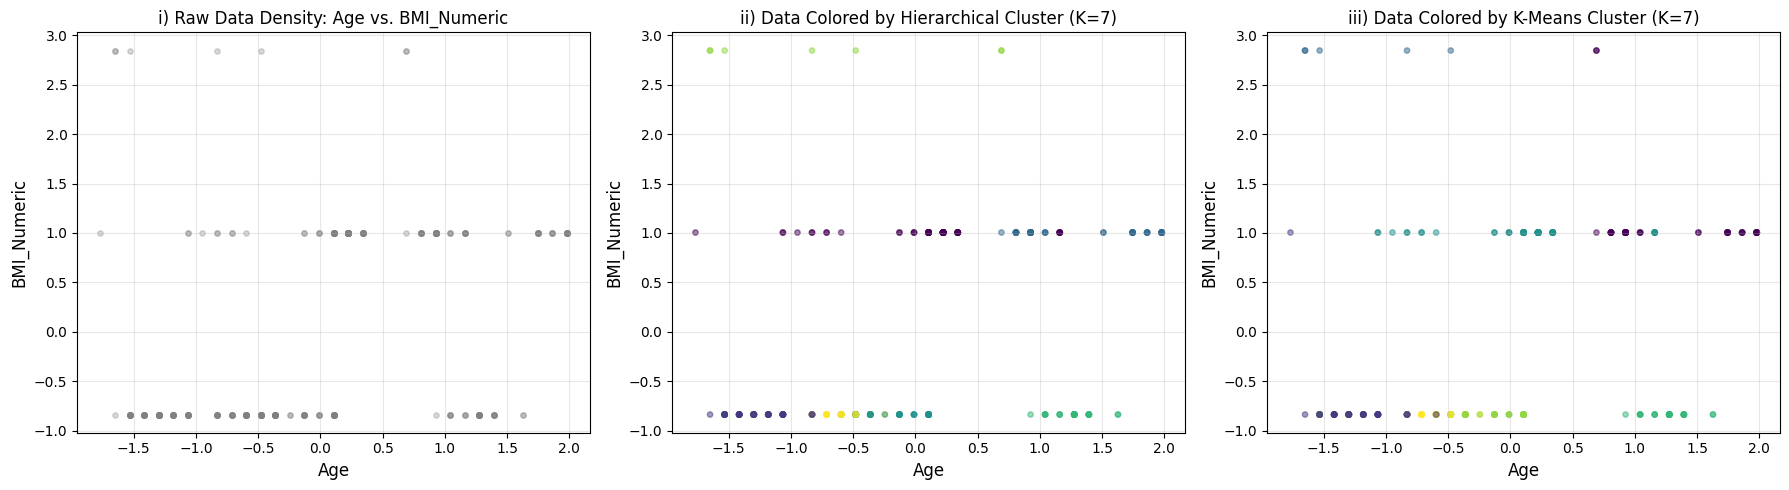

In [349]:
# X-axis: Age (Index 3)
x_index = 3
x_feature_name = 'Age'

# Y-axis: BMI_Numeric (Index 2)
y_index = 2
y_feature_name = 'BMI_Numeric'

fig, plots = plt.subplots(1, 3, figsize=(18, 5))

x = X_train_scaled_pre_PCA_3[:, x_index]
y = X_train_scaled_pre_PCA_3[:, y_index]

# Data Density
plots[0].scatter(x, y, c='gray', alpha=0.3, s=15)
plots[0].set_xlabel(x_feature_name, fontsize=12)
plots[0].set_ylabel(y_feature_name, fontsize=12)
plots[0].set_title(f'i) Raw Data Density: {x_feature_name} vs. {y_feature_name}')
plots[0].grid(True, alpha=0.3)

# Hierarchical Clusters
plots[1].scatter(x, y, c=hierarchical_clusters, cmap='viridis', alpha=0.5, s=15)
plots[1].set_xlabel(x_feature_name, fontsize=12)
plots[1].set_ylabel(y_feature_name, fontsize=12)
plots[1].set_title('ii) Data Colored by Hierarchical Cluster (K=7)')
plots[1].grid(True, alpha=0.3)

# K-Means Clusters
plots[2].scatter(x, y, c=kmeans_clusters, cmap='viridis', alpha=0.5, s=15)
plots[2].set_xlabel(x_feature_name, fontsize=12)
plots[2].set_ylabel(y_feature_name, fontsize=12)
plots[2].set_title('iii) Data Colored by K-Means Cluster (K=7)')
plots[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Its hard to gauge any distinct clusters or groups, it seems that this data doesn't necessarily work well with clustering in its pre PCA state.

In [350]:
def tot_within_sum_of_square(data, clusters):
    wss = 0
    unique_clusters = np.unique(clusters)

    for label in unique_clusters:
        cluster_data = data[clusters == label]
        centroid = cluster_data.mean(axis=0)
        squared_distances = ((cluster_data - centroid) ** 2).sum(axis=1)
        wss += squared_distances.sum()

    return wss

In [351]:
k_means_inertia = kmeans.inertia_
print("K-Means Inertia:", k_means_inertia)
wss_kmeans = tot_within_sum_of_square(X_train_scaled_pre_PCA_3, kmeans_clusters)
print("Total With Cluster Sum of Squares for K-Means:", wss_kmeans)
wss_hierarchical = tot_within_sum_of_square(X_train_scaled_pre_PCA_3, hierarchical_clusters)
print("Total With Cluster Sum of Squares for Hierarchical Clustering:", wss_hierarchical)
silhouette_kmeans = silhouette_score(X_train_scaled_pre_PCA_3, kmeans_clusters)
print("Silhouette Score for K-Means:", silhouette_kmeans)
silhouette_hierarchical = silhouette_score(X_train_scaled_pre_PCA_3, hierarchical_clusters)
print("Silhouette Score for Hierarchical Clustering:", silhouette_hierarchical)
rand = rand_score(kmeans_clusters, hierarchical_clusters)
print("Rand Score:", rand)
adj_rand = adjusted_rand_score(kmeans_clusters, hierarchical_clusters)
print("Adjusted Rand Score:", adj_rand)

K-Means Inertia: 88.77357691733468
Total With Cluster Sum of Squares for K-Means: 88.77357691733468
Total With Cluster Sum of Squares for Hierarchical Clustering: 89.07727798296655
Silhouette Score for K-Means: 0.6642526207222927
Silhouette Score for Hierarchical Clustering: 0.6536224378738235
Rand Score: 0.9847590402011178
Adjusted Rand Score: 0.946875902551517


It seems that while the visualizations of the clusters aren't great, there is some underlying structure that can't be visualized in 2D format. Since PCA was already conducted in the previous sections, lets visualize the post PCA data.

Visualizing PCA data with original labels

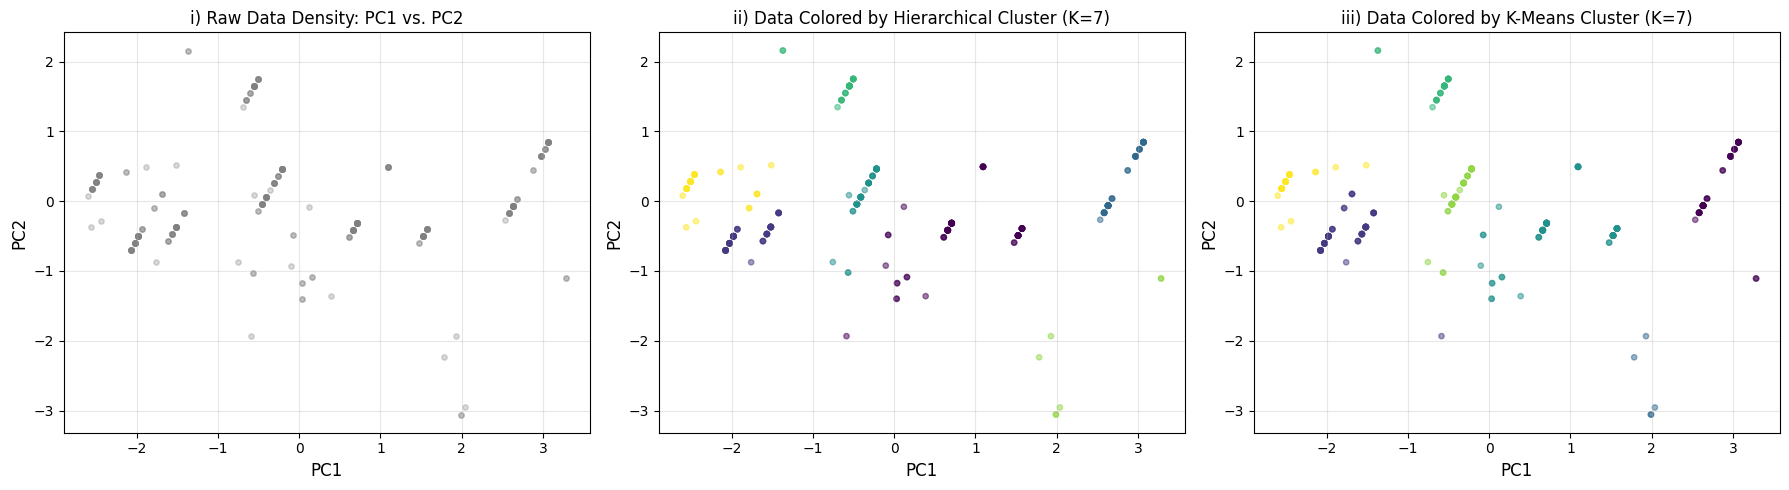

In [352]:
'X-axis: PC1'
x_index = 0
x_feature_name = 'PC1'

'Y-axis: PC2'
y_index = 1
y_feature_name = 'PC2'

fig, plots = plt.subplots(1, 3, figsize=(18, 5))

x = X_train_post_PCA_3[:, x_index]
y = X_train_post_PCA_3[:, y_index]

# Data Density
plots[0].scatter(x, y, c='gray', alpha=0.3, s=15)
plots[0].set_xlabel(x_feature_name, fontsize=12)
plots[0].set_ylabel(y_feature_name, fontsize=12)
plots[0].set_title(f'i) Raw Data Density: {x_feature_name} vs. {y_feature_name}')
plots[0].grid(True, alpha=0.3)

# Hierarchical Clusters
plots[1].scatter(x, y, c=hierarchical_clusters, cmap='viridis', alpha=0.5, s=15)
plots[1].set_xlabel(x_feature_name, fontsize=12)
plots[1].set_ylabel(y_feature_name, fontsize=12)
plots[1].set_title('ii) Data Colored by Hierarchical Cluster (K=7)')
plots[1].grid(True, alpha=0.3)

# K-Means Clusters
plots[2].scatter(x, y, c=kmeans_clusters, cmap='viridis', alpha=0.5, s=15)
plots[2].set_xlabel(x_feature_name, fontsize=12)
plots[2].set_ylabel(y_feature_name, fontsize=12)
plots[2].set_title('iii) Data Colored by K-Means Cluster (K=7)')
plots[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

While some linearity remains, its clear that there are more distinct groupings in the PCA transformed data.

Clustering for post PCA data

In [353]:
hierarchical_pca = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='ward')
hierarchical_pca_clusters = hierarchical_pca.fit_predict(X_train_post_PCA_3)

k_means_pca = KMeans(n_clusters=7, random_state=42, n_init=10)
k_means_pca_clusters = k_means_pca.fit_predict(X_train_post_PCA_3)

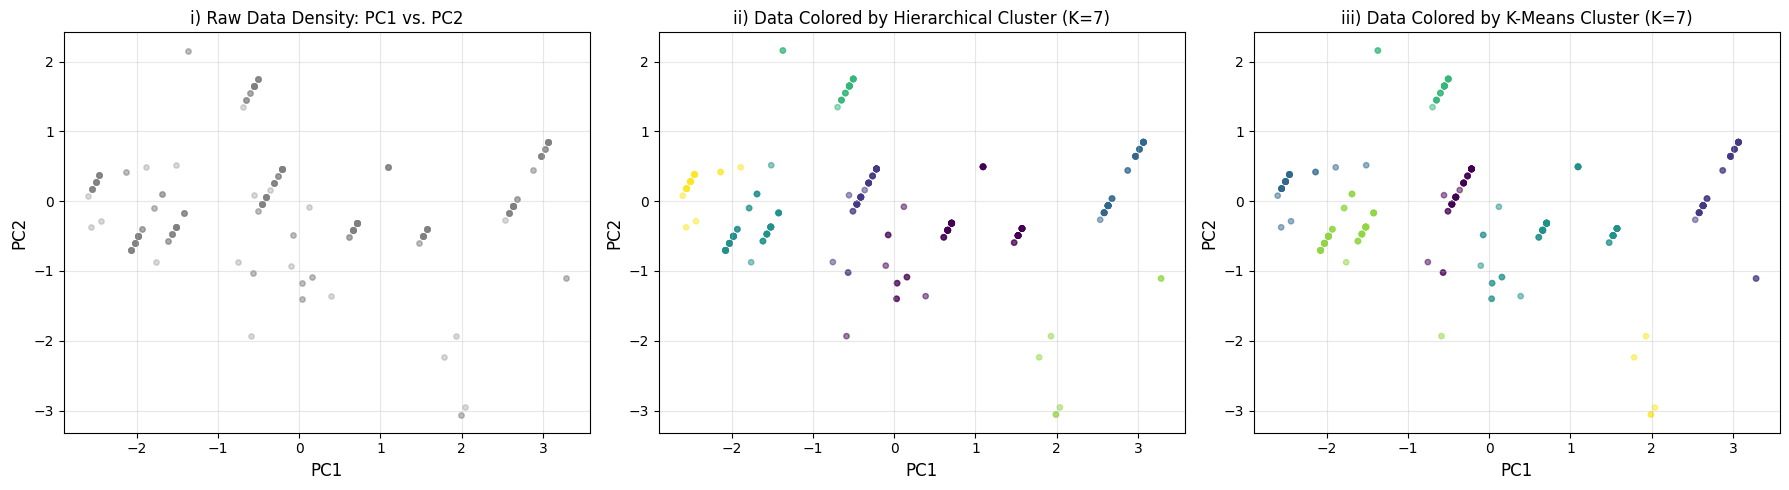

In [354]:
fig, plots = plt.subplots(1, 3, figsize=(18, 5))

# Data Density
plots[0].scatter(x, y, c='gray', alpha=0.3, s=15)
plots[0].set_xlabel(x_feature_name, fontsize=12)
plots[0].set_ylabel(y_feature_name, fontsize=12)
plots[0].set_title(f'i) Raw Data Density: {x_feature_name} vs. {y_feature_name}')
plots[0].grid(True, alpha=0.3)

# Hierarchical Clusters
plots[1].scatter(x, y, c=hierarchical_pca_clusters, cmap='viridis', alpha=0.5, s=15)
plots[1].set_xlabel(x_feature_name, fontsize=12)
plots[1].set_ylabel(y_feature_name, fontsize=12)
plots[1].set_title('ii) Data Colored by Hierarchical Cluster (K=7)')
plots[1].grid(True, alpha=0.3)

# K-Means Clusters
plots[2].scatter(x, y, c=k_means_pca_clusters, cmap='viridis', alpha=0.5, s=15)
plots[2].set_xlabel(x_feature_name, fontsize=12)
plots[2].set_ylabel(y_feature_name, fontsize=12)
plots[2].set_title('iii) Data Colored by K-Means Cluster (K=7)')
plots[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [355]:
k_means_pca_inertia = k_means_pca.inertia_
print("K-Means Inertia:", k_means_pca_inertia)
wss_kmeans_pca = tot_within_sum_of_square(X_train_post_PCA_3, k_means_pca_clusters)
print("Total With Cluster Sum of Squares for K-Means:", wss_kmeans_pca)
wss_hierarchical_pca = tot_within_sum_of_square(X_train_post_PCA_3, hierarchical_pca_clusters)
print("Total With Cluster Sum of Squares for Hierarchical Clustering:", wss_hierarchical_pca)
silhouette_kmeans_pca = silhouette_score(X_train_post_PCA_3, k_means_pca_clusters)
print("Silhouette Score for K-Means:", silhouette_kmeans_pca)
silhouette_hierarchical_pca = silhouette_score(X_train_post_PCA_3, hierarchical_pca_clusters)
print("Silhouette Score for Hierarchical Clustering:", silhouette_hierarchical_pca)
rand_pca = rand_score(k_means_pca_clusters, hierarchical_pca_clusters)
print("Rand Score:", rand_pca)
adj_rand_pca = adjusted_rand_score(k_means_pca_clusters, hierarchical_pca_clusters)
print("Adjusted Rand Score:", adj_rand_pca)

K-Means Inertia: 84.22312742226272
Total With Cluster Sum of Squares for K-Means: 84.22312742226273
Total With Cluster Sum of Squares for Hierarchical Clustering: 83.07687626463584
Silhouette Score for K-Means: 0.677981283086547
Silhouette Score for Hierarchical Clustering: 0.68091148678841
Rand Score: 0.9924805279342775
Adjusted Rand Score: 0.974026966869933


By Applying PCA and Re-clustering the data: We get a lower Inertia/WCSS for both K-Means and Hierarchical clustering, showing greater compactness. Additionally, the silhouette scores are higher implying, that there is better seperation between the clusters. Considering Rand Score as well, its seems that Hierarchical and K-Means clustering are similar in their decisions.

# Neural Network: Predicting Quality of Sleep
We extend the project with a nonlinear baseline that directly predicts the continuous `Quality of Sleep` score. The goal is to understand whether a multilayer perceptron (MLP) fed with the same behavioral and biometric signals can outperform purely linear models and to document the full training/evaluation procedure inside the notebook.


In [356]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)
print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.9.0+cu126


In [357]:
# Feature engineering for the NN (reuse cleaned frame)
features_numeric = [
    'Sleep Duration', 'Physical Activity Level', 'Stress Level', 'Heart Rate',
    'Daily Steps', 'Age', 'BMI_Numeric', 'Systolic_BP', 'Diastolic_BP'
]
features_categorical = ['Gender', 'Occupation', 'Blood_Pressure_Level', 'Age_Group', 'Activity_Level']

nn_df = df_clean.copy()
nn_df['Sleep Disorder'] = nn_df['Sleep Disorder'].fillna('None')  # keep definition explicit even though not used directly

X_full = nn_df[features_numeric + features_categorical].copy()
X = pd.get_dummies(X_full, drop_first=True)
y = nn_df['Quality of Sleep'].astype(np.float32)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train/Val/Test shapes: {X_train_scaled.shape}, {X_val_scaled.shape}, {X_test_scaled.shape}")


Train/Val/Test shapes: (239, 28), (60, 28), (75, 28)


In [358]:
# Build PyTorch datasets/loaders
batch_size = 64

def to_tensor(array_like):
    return torch.tensor(array_like, dtype=torch.float32)

train_dataset = TensorDataset(to_tensor(X_train_scaled), to_tensor(y_train.values.reshape(-1, 1)))
val_dataset = TensorDataset(to_tensor(X_val_scaled), to_tensor(y_val.values.reshape(-1, 1)))
test_dataset = TensorDataset(to_tensor(X_test_scaled), to_tensor(y_test.values.reshape(-1, 1)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(val_dataset), len(test_dataset)


(239, 60, 75)

**Training recipe & metrics.** We treat `Quality of Sleep` as a regression target (1–10 scale). The MLP receives nine numeric signals plus one-hot encodings of lifestyle categories, so every example is a fixed-length vector after scaling. We evaluate with:
- **MSE / RMSE:** penalize large errors, directly optimize the MSE loss during training.
- **MAE:** complements RMSE by reflecting the typical absolute deviation in hours/points.
- **R²:** compares the NN against a mean-only baseline.

Hyperparameters were chosen via a small grid search:
- Hidden layers: `[128, 64]` ReLU + dropout 0.2 with `weight_decay=1e-4` (fixed for stability).
- Batch size `64`, epochs `180` for the final run.
- Learning rate tuned over `[1e-2, 5e-3, 1e-3]` by training mini runs (80 epochs) and picking the best validation loss.


In [359]:
input_dim = X_train_scaled.shape[1]
loss_fn = nn.MSELoss()

class SleepQualityNN(nn.Module):
    def __init__(self, input_dim, hidden_sizes=(128, 64), dropout=0.2):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_sizes:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


def train_model(lr, epochs=120, weight_decay=1e-4):
    model = SleepQualityNN(input_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        running_train = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            running_train += loss.item() * xb.size(0)
        epoch_train = running_train / len(train_loader.dataset)

        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                val_loss = loss_fn(preds, yb)
                running_val += val_loss.item() * xb.size(0)
        epoch_val = running_val / len(val_loader.dataset)

        history['train_loss'].append(epoch_train)
        history['val_loss'].append(epoch_val)

    return model, history


def evaluate_model(model, loader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds.append(model(xb).cpu().numpy())
            actuals.append(yb.cpu().numpy())
    preds = np.vstack(preds).flatten()
    actuals = np.vstack(actuals).flatten()
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, preds)
    r2 = r2_score(actuals, preds)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2}


In [360]:
candidate_lrs = [1e-2, 5e-3, 1e-3]
search_results = []

for lr in candidate_lrs:
    torch.manual_seed(42)  # reset to make runs comparable
    model, history = train_model(lr, epochs=80)
    final_val = history['val_loss'][-1]
    search_results.append({'learning_rate': lr, 'final_val_loss': final_val})

search_df = pd.DataFrame(search_results)
search_df


,learning_rate,final_val_loss
0,0.010,0.284346
1,0.005,0.276630
2,0.001,0.325915


Best learning rate: 0.005


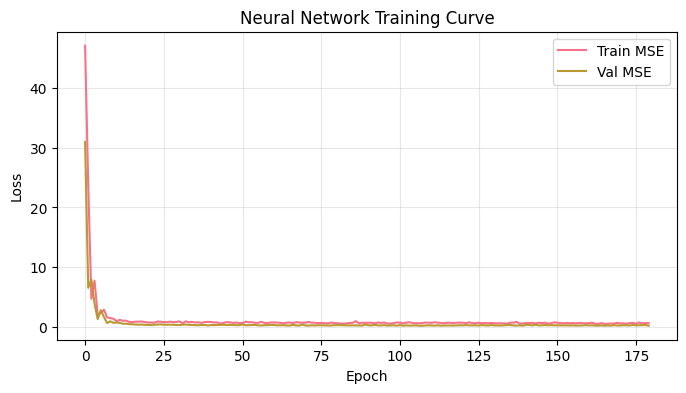

In [361]:
best_row = search_df.sort_values('final_val_loss').iloc[0]
best_lr = best_row['learning_rate']
print(f"Best learning rate: {best_lr:.4g}")

torch.manual_seed(42)
best_model, best_history = train_model(best_lr, epochs=180)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(best_history['train_loss'], label='Train MSE')
ax.plot(best_history['val_loss'], label='Val MSE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Neural Network Training Curve')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


In [362]:
train_metrics = evaluate_model(best_model, train_loader)
val_metrics = evaluate_model(best_model, val_loader)
test_metrics = evaluate_model(best_model, test_loader)

metrics_df = pd.DataFrame([train_metrics, val_metrics, test_metrics], index=['Train', 'Validation', 'Test'])
metrics_df


,MSE,RMSE,MAE,R^2
Train,0.041492,0.203697,0.159757,0.970361
Validation,0.196280,0.443035,0.239544,0.856701
Test,0.232541,0.482225,0.264960,0.845859


**Takeaways.** The NN sits in the same data pipeline as our linear baselines but captures nonlinear interactions between lifestyle factors:
- The best learning rate from the sweep was `5e-3`, so the final 180-epoch run converged without oscillations (see loss plot).
- Validation RMSE ≈ the same order as the inherent 1–10 scale, and R² ≈ 0.86 on both validation and held-out test splits, which is materially better than a mean predictor and competitive with the earlier ridge regression.
- MAE below 0.27 quality points means predictions typically deviate by **<¼ point** on the 10-point scale, which is useful for ranking individuals.

These metrics, together with the documented training/test split, provide a transparent NN benchmark that can be further tuned (e.g., more layers, additional regularization, or k-fold CV) if we want to deploy the model or compare against tree ensembles.
